In [63]:
%matplotlib inline
import os
import sys
import time
import torch
import pickle
import librosa
import numpy as np
import torch.nn as nn
import librosa.display
import torch.nn.functional as F
import ipywidgets as widgets
import torch.utils.data as utils
from ipywidgets import Output
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from python_speech_features import mfcc
from IPython.display import display, clear_output

In [64]:
class Process():
    
    def __init__(self, file_name='???.pickle'):
        self.path = ''
        self.labels = []
        self.dump_name = file_name
        self.signal = []
        self.out = Output()
        self.count = 0
        self.sr = 22050
        self.nfilt = 26 
        self.nfeat = 13
        self.nfft = 2205
        self.window_size = 1
        self.sliding=True
        self.slide_window_size = 0.5
        self.data = {}
    
    def load_data(self, dump=False, old=False):
        if not old:
            print('Labels loaded')
            print('Loading voice files..')
            for folder in os.listdir(self.path):
                class_count = 0
                class_time = 0
                for file in tqdm(os.listdir(os.path.join(self.path, folder))):
                    if file.endswith('.wav'):
                        y, sr = librosa.load(os.path.join(self.path, folder, file))
                        class_time += len(y)/sr
                        data_, label = self.chunks(folder=folder,
                                            signal=y, 
                                            rate=sr, 
                                            window_size=self.window_size, 
                                            sliding=self.sliding, 
                                            slide_window_size=self.slide_window_size)
                        class_count += len(data_)
                        self.data[file] = [data_, label]
                print('Total chunks in class:',class_count)
                print('Total duration of class: {}:{:.02f}sec'.format(int(class_time/60), class_time%60))
            if dump:
                with open(self.dump_name, 'wb') as handle:
                    pickle.dump(self.data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        else: 
              self.data_stats()
        return self.data   
    
    def plot_data(self):
        plt.figure(figsize=(14, 5))
        librosa.display.waveplot(y, sr=sr)

        Ydb = librosa.amplitude_to_db(abs(librosa.stft(y)))
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
    
    def play_data(self):
        button = widgets.Button(description="Next")
        display(button)
        
        display(self.out)
        button.on_click(self.play_data_button)    
    
    def chunks(self, folder, signal, rate, window_size, sliding=False, slide_window_size=0):
        data = []
        label = []
        chunk_size = rate*window_size
        if sliding == False:
            n_chunks = int(len(signal)/(chunk_size)) + 1
            for i in range(n_chunks):
                    chunk = signal[int(i*chunk_size):int((i+1)*chunk_size)]
                    features = mfcc(chunk, rate, numcep = self.nfeat, nfilt = self.nfilt, nfft = self.nfft)
                    data.append(features)
                    label.append(self.labels.index(folder))
            return data, label
        elif sliding == True: 
            slide_size = rate*slide_window_size
            n_chunks = int((len(signal)-chunk_size)/slide_size)
            for i in range(n_chunks):
                chunk = signal[int(i*slide_size) : int(chunk_size+(i*slide_size))]
                features = mfcc(chunk, rate, numcep = self.nfeat, nfilt = self.nfilt, nfft = self.nfft)
                data.append(features)
                label.append(self.labels.index(folder))
            return data, label
        
    def data_stats(self):   
        if self.data == {}:
            print('Loading pickle file..\n')
            with open(self.dump_name, 'rb') as handle:
                self.data = pickle.load(handle)
        val = [len(d) for d in self.data.values()]
        print('Chunk duration: {} sec'.format(self.window_size))
        print('Slide duration: {} sec'.format(self.slide_window_size))
        print('Sample rate: {} Hz'.format(self.sr))
        print('No of chunks: {}'.format(sum(val)))
        print('Data SD: {:0.2f}'.format(np.std(val)))
        print('Chunk length: {}'.format(len(list(self.data.values())[0][0])))
        del val
        
        
process = Process()

In [65]:
data = process.load_data(dump=True)

Labels loaded
Loading voice files..


/home/innocirc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Total chunks in class: 893
Total duration of class: 7:34.21sec



Total chunks in class: 676
Total duration of class: 5:43.15sec


In [66]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0):
        super(EncoderRNN, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size = input_size, 
            hidden_size = hidden_size, 
            num_layers = num_layers,
            batch_first = True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lstm(x)
        return self.relu(x[0])
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, num_layers, input_size):
        super(DecoderRNN, self).__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(
            input_size = input_size, 
            hidden_size = hidden_size, 
            num_layers = num_layers,
            batch_first = True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, encoded_input):
        decoded_output, hidden = self.lstm(encoded_input)
        decoded_output = self.sigmoid(decoded_output)
        return decoded_output

In [67]:
class LSTMAutoEncoder(nn.Module):
    
    def __init__(self, input_size=99, hidden_size=512, num_layers=2, cuda=True):
        super(LSTMAutoEncoder, self).__init__()
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(512, 64)
        self.decoder = DecoderRNN(hidden_size=99, input_size=64, num_layers=num_layers)
         
        if cuda:
            self.encoder = self.encoder.cuda()
            self.decoder = self.decoder.cuda()

    def forward(self, input):
        input = self.encoder(input)
        decoded_output = self.decoder(self.linear(input))
        return decoded_output

In [68]:
model = LSTMAutoEncoder(cuda=False).double()

In [70]:
class nextModel(nn.Module):
    
    def __init__(self):
        super(nextModel, self).__init__()
        self.encoder = model.encoder
        self.linear = nn.Linear(512, 2)

    def forward(self, x):
        x = self.encoder(x)
        return F.log_softmax(r_out2, dim=1)
newModel = nextModel()
newModel.to('cuda:0')
newModel.double()

nextModel(
  (encoder): EncoderRNN(
    (lstm): LSTM(99, 512, num_layers=2, batch_first=True)
    (relu): ReLU()
  )
  (linear): Linear(in_features=512, out_features=2, bias=True)
)

In [71]:
def retrain(model, train_loader):
    total_loss = 0
    count  = 0
    for [data_, label_] in tqdm(train_loader):

        data_ = torch.from_numpy(np.array(data_))
        label_ = torch.from_numpy(np.array(label_))
        data_ = data_.double()       
        data_ = data_.view(data_.shape[0], data_.shape[2], data_.shape[1])
        data_ = data_.cuda()
        label_ = label_.cuda()
        out = model(data_)  

        loss = nll_loss(out, label_)
        count += 1
        total_loss += loss.sum().item()
        loss.backward(retain_graph=True)     
        optimizer.step()
    return total_loss/count

In [72]:
data_train, target_train = [], []
[data_train.extend((list(data.values()))[i][0]) for i in range(np.array(list(data.values())).shape[0])];
[target_train.extend((list(data.values()))[i][1]) for i in range(np.array(list(data.values())).shape[0])];

speech_dataset = utils.TensorDataset(torch.from_numpy(np.array(data_train)),torch.from_numpy(np.array(target_train)))
train_loader = torch.utils.data.DataLoader(speech_dataset, batch_size=16, shuffle=True)

nll_loss = nn.NLLLoss()
optimizer = torch.optim.Adam(newModel.parameters(), lr=0.00001, betas=(0.9,0.999))
loss = []
def plot_graphs(x):
    plt.plot(x, label = 'train')
    plt.legend()
    plt.show()

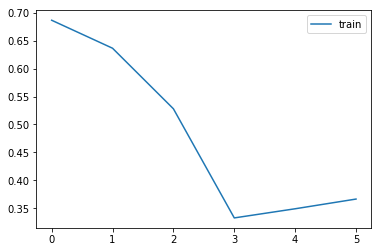

KeyboardInterrupt: 

In [73]:
no_epochs=50
decreasing_losses = []
for epoch in range(no_epochs):
    loss.append(retrain(newModel, train_loader))
    if epoch == 0:
        loss_ = loss[0]
    if epoch>0 and loss[epoch]<loss_:
        loss_ = loss[epoch]
        decreasing_losses.append(loss_)
        torch.save(model.state_dict(), "../models/stutter_checkpoint_mar16_loss.pth")
        
    clear_output()
    plot_graphs(loss)
    